In [17]:
# Internal imports
import os
import pickle

# External imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import corner
import seaborn as sns
sns.set_theme()
import arviz as az

import pymc3 as pm 
import theano.tensor as tt

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

#### Import data from file
Split data into full $z$-range and low-$z$-range ($z<0.5$, prefixed with 'low_').

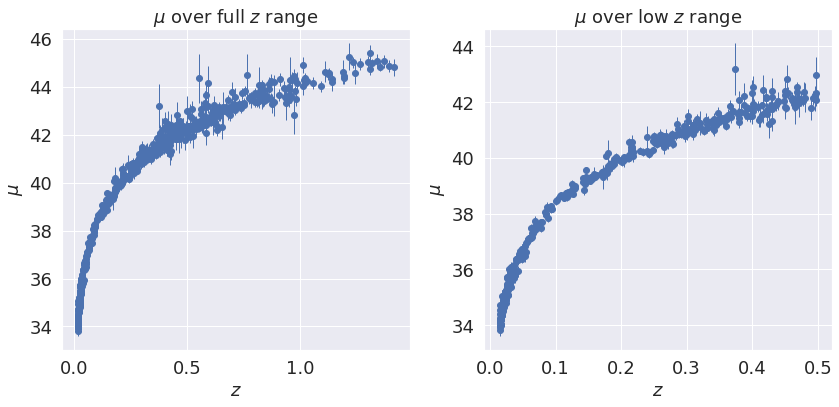

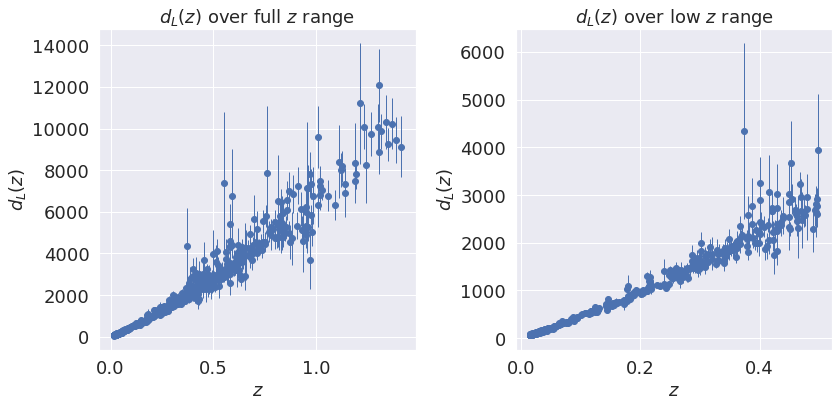

In [18]:
### Imported data
z = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 1)
mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 2)
delta_mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 3)
data4 = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 4)

### Sort data for increasing z
sortOrder = np.argsort(z)
z = z[sortOrder]
mu = mu[sortOrder]
delta_mu = delta_mu[sortOrder]
dl = 10**(mu/5-5) # Extract dl(z) from modulus

### Extract low-z-range
low_ind = np.where(z<0.5)
low_z = z[low_ind]
low_mu = mu[low_ind]
low_delta_mu = delta_mu[low_ind]

delta_dl = dl*np.log(10)*delta_mu/5
low_dl = 10**(low_mu/5-5)
low_delta_dl = low_dl*np.log(10)*low_delta_mu/5

### Plot the data
fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,mu)
ax[0].errorbar(z,mu,delta_mu, linewidth = 0, elinewidth = 1)

ax[1].scatter(low_z,low_mu)
ax[1].errorbar(low_z,low_mu,low_delta_mu, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$\mu$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\mu$')
ax[1].set_title(r'$\mu$ over low $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\mu$')
plt.tight_layout()


fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,dl)
ax[0].errorbar(z,dl,delta_dl, linewidth = 0, elinewidth = 1)
ax[1].scatter(low_z,low_dl)
ax[1].errorbar(low_z,low_dl,low_delta_dl, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$d_L(z)$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$d_L(z)$')
ax[1].set_title(r'$d_L(z)$ over low $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$d_L(z)$')

plt.tight_layout()

#### Define model
Defines models for $\mu$ and $d_L(z)$, introducing our parameters (random variables) $H_0$ and $q_0$. Note that we set  $c=1$ here, i.e. $c$ is baked into the value for $H_0$. In the treatment below we call this value $\theta = \frac{H_0}{c}$.

In [19]:
def mu_model(z, theta, q0):
    return np.log10(dl_model(z,theta,q0))*5 + 25
    
def dl_model(z, theta, q0):
    return 1/theta*(z + 1/2*(1-q0)*z**2)

#### PyMC3 setup - Define priors and likelihood
Defines our PyMC3 models. We use uniform priors for $H_0$ and $q_0$. We use 

$$ 
    \theta \sim \mathcal{U}(0, 0.01) \\
    q_0 \sim \mathcal{U}(-100, 100)
$$

We also introduce a weight matrix $\mathbf{W}$, to weight each datapoint according to its associated error. $\mathbf{W}$ is normalized so that $\sum_i w_i = N_d$ where N_d is the number of datapoints. $\mathbf{W}$ is then inverted to obtain a matrix proportional to the covariance $\Sigma$, but since we do not know the absolute overall scale we introduce an error scale parameter $\sigma^2$, with an inverse gamma prior distribution:

$$
    \sigma^2 \sim \mathcal{IG}(\alpha=1,\beta=1)
$$
Finally, since we deal with heteroscedastic errors (hence the covariance matrix) we need to use a multivariate normal distribution in our likelihood, which we then write as

$$
    p(\mathcal{D}|\theta, q_0, \sigma^2, I) = \frac{1}{\sqrt{(2 \pi)^{N_d} |\Sigma|}} \exp{\left(-\frac{1}{2} \left(\mathbf{\hat{y}} - \mathcal{D} \right)^T \Sigma^{-1} \left(\mathbf{\hat{y}} - \mathcal{D} \right)\right)} \\
    \Sigma = \sigma^2 \mathbf{W}^{-1}
$$
where $\mathcal{D}$ are the collected values for $d_L(z)$, and $\mathbf{\hat{y}}$ is our model output at the same $z$-values that $\mathcal{D}$ is sampled at.

In [20]:
W = np.diag(low_delta_mu**(-2))
W_dl = len(low_z)*(low_delta_dl**(-2))/((low_delta_dl**(-2)).sum())
cov = np.diag(1/W_dl)

W_mu = len(low_z)*(low_delta_mu**(-2))/((low_delta_mu**(-2)).sum())
cov_mu = np.diag(1/W_mu)
 
our_mu_model = pm.Model()
with our_mu_model:
    theta = pm.Uniform("theta", lower = 0.0001668, upper = 0.000336, shape = 1) # theta = 1/H0
    q0 = pm.Uniform("q0", lower = -2, upper = 2, shape = 1)
    
    alpha = 0.121851859725
    beta = 2.46569277393
    sigma2 = pm.InverseGamma("sigma2", alpha, beta)
    
    dl_m = 1/theta*(low_z + 1/2*(1-q0)*low_z**2)
    mu_m = np.log10(dl_m)*5 + 25

    #mu_obs = pm.Normal('mu_obs', mu=mu_m, sd=tt.sqrt(sigma2), observed=low_mu)
    mu_obs = pm.MvNormal('mu_obs', mu=mu_m, cov=sigma2*cov_mu, observed=low_mu)

    
our_dl_model = pm.Model()
with our_dl_model:
    # Priors for model parameters and scale parameter sigma
    theta = pm.Uniform("theta", lower = 0, upper = 0.01, shape = 1)
    q0 = pm.Uniform("q0", lower = -100, upper = 100, shape = 1)
    
    # alpha and beta from data file
    alpha = 0.121851859725
    beta = 2.46569277393
    sigma2 = pm.InverseGamma("sigma2", alpha=alpha, beta=beta)

    # Model output given our distributions for theta, q0 and sigma2
    dl_m = 1/theta*(low_z + 1/2*(1-q0)*low_z**2)    
    dl_obs = pm.MvNormal('dl_obs', mu=dl_m, cov=sigma2*cov, observed=low_dl)

In [21]:
### MAP estimate
# Perform as a first check
map_estimate = pm.find_MAP(model=our_dl_model)

theta = map_estimate['theta'][0]
q0 = map_estimate['q0'][0]
s2  = map_estimate['sigma2']

c = 299792458
print(f'theta = {theta:.6f} => H0 = {theta*c} \nq0 = {q0:.3f}\nsigma2 = {s2:.3f}')


theta = 0.000234 => H0 = 70254.77804374036 
q0 = -0.409
sigma2 = 177.832


In [22]:
map_estimate = pm.find_MAP(model=our_mu_model)
theta = map_estimate['theta'][0]
q0 = map_estimate['q0'][0]
s2  = map_estimate['sigma2']

c = 299792458
print(f'theta = {theta:.6f} => H0 = {theta*c} \nq0 = {q0:.3f}\nsigma2 = {s2:.3f}')


theta = 0.000233 => H0 = 69783.88475010973 
q0 = -0.419
sigma2 = 0.036


#### Sample posterior using NUTS

In [23]:
with our_mu_model:
    if(os.path.isfile('trace_NUTS_mu_task1.p')):
        print('Using pickled trace')
        trace_NUTS_mu = pickle.load( open( 'trace_NUTS_mu_task1.p', 'rb' ) )
    else:
        print('No trace file found. Running NUTS sampler')
        trace_NUTS_mu = pm.sample(4000, cores=4, chains=4, tune=2000)
        pickle.dump(trace_NUTS_mu, open( "trace_NUTS_mu_task1.p", "wb" ))

Using pickled trace


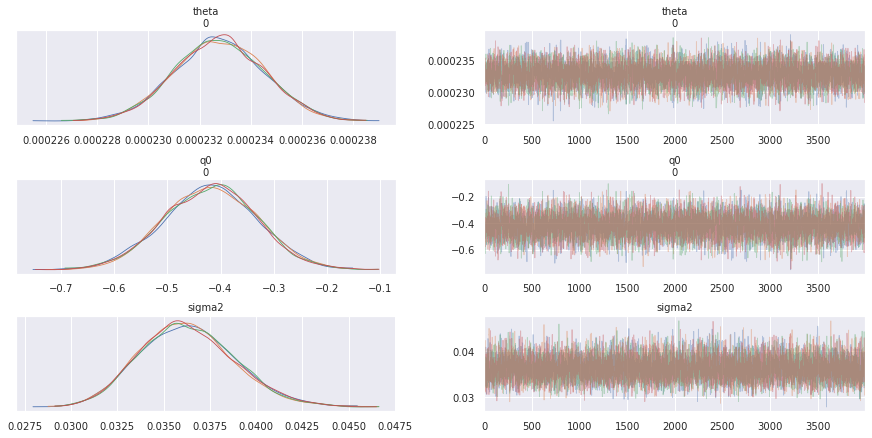

In [24]:
with our_mu_model:
    az.plot_trace(trace_NUTS_mu);

In [25]:
with our_dl_model:
    if(os.path.isfile('trace_NUTS_task1.p')):
        print('Using pickled trace')
        trace_NUTS = pickle.load( open( 'trace_NUTS_task1.p', 'rb' ) )
    else:
        print('No trace file found. Running NUTS sampler')
        trace_NUTS = pm.sample(4000, cores=4, chains=4, tune=2000)
        pickle.dump(trace_NUTS, open( "trace_NUTS_task1.p", "wb" ))

Using pickled trace


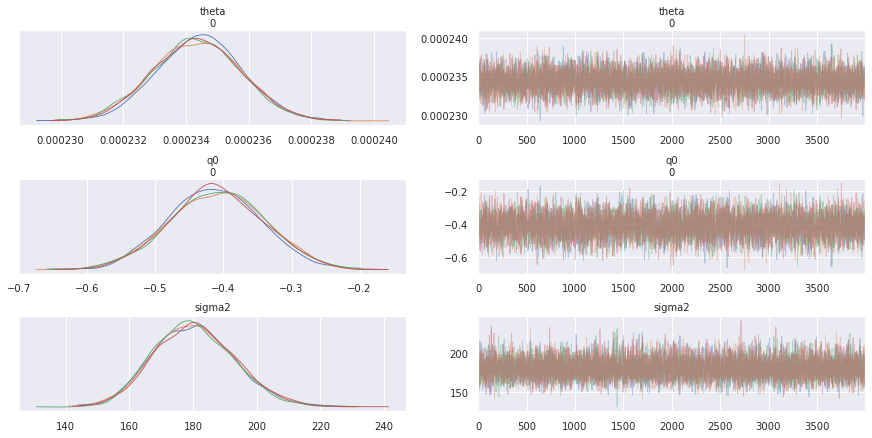

In [26]:
with our_dl_model:
    az.plot_trace(trace_NUTS);

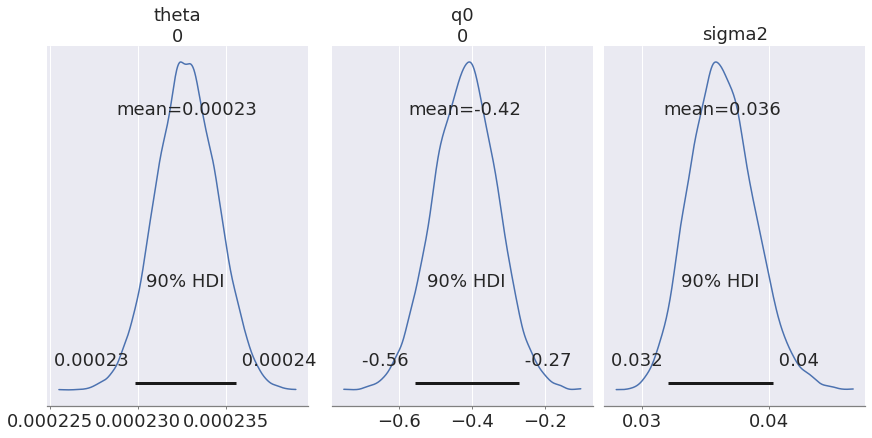

In [27]:
# or plot only marginalized posteriors with some mean and highest_density_intervals
with our_dl_model:
    az.plot_posterior(trace_NUTS_mu,figsize=(12, 6),hdi_prob=0.9);

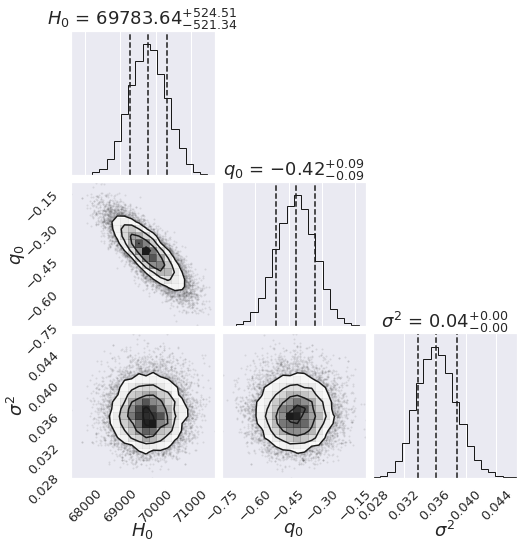

In [32]:
# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

#samples = np.vstack([trace_NUTS['theta'][:,k] for k in range(0,len(trace_NUTS['theta'][0]))])
samples = np.vstack(trace_NUTS_mu['theta'][:]*c).T
samples = np.vstack((samples,trace_NUTS_mu['q0'][:].T))
samples = np.vstack((samples,(trace_NUTS_mu['sigma2'][:]).T)).T

fig_corner = corner.corner(samples,labels =[r'$H_0$', '$q_0$','$\\sigma^2$'], show_titles=True, quantiles=[0.16, 0.5, 0.84]);
plt.savefig('figures_task1/corner.png')

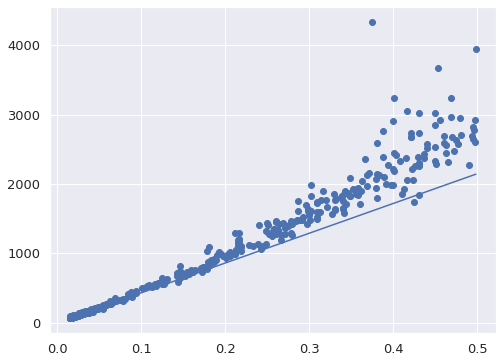

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(low_z, low_z*1/theta)
ax.scatter(low_z, low_dl)

#### Posterior predictive plot
Perform a posterior predictive plot using the samples from the posterior. 

/home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


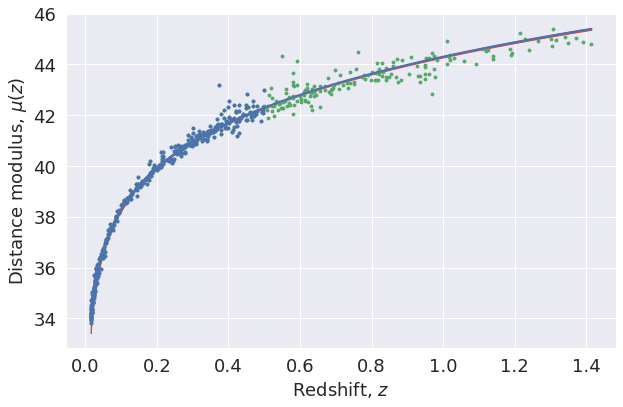

In [30]:
# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

with our_dl_model:
    posterior_draws = pm.sample_posterior_predictive(trace_NUTS, var_names=["theta", "q0", "sigma2"], 
                                                     samples=50, random_seed=123);
fig, ax = plt.subplots(figsize=(9,6))
sample_trajectories = np.zeros((posterior_draws['theta'].shape[0], len(z)))
for idx, theta_sample in enumerate(posterior_draws['theta']):
    epsilon = np.random.normal(scale=np.sqrt(posterior_draws['sigma2'][idx]))
    # Add noise and calculate one sample of dl(z)
    dl_sample = dl_model(z, theta_sample,posterior_draws['q0'][idx]) + epsilon
    # Convert the sample to mu
    mu_sample = 5*np.log10(dl_sample) + 25 
#     mu_sample = dl_sample
    # Save and plot the mu sample
    sample_trajectories[idx, :] = mu_sample
#     if(idx == 0):
#         ax.plot(z, mu_sample, color='black',alpha=1, label='Posterior sample of $\mu_{model}(z, \\theta, q_0,\sigma)$')
#     else: 
#         ax.plot(z, mu_sample, color='black',alpha=0.05)

# Plot mean posterior predictive and +-1 sigma band
mu_mean = np.mean(sample_trajectories, axis=0)
# mu_mean = 5*np.log10(mu_mean)+25
mu_std = np.std(sample_trajectories, axis=0)
# mu_std = 5/mu_mean * mu_std/np.log(10)
ax.fill_between(x=z, y1=mu_mean+mu_std, y2=mu_mean-mu_std, color='r', label='$\overline{\mu_{model}} \pm \sigma_{sampled} $')
ax.plot(z, mu_mean, c='b', linewidth=2, label='$\overline{\mu_{model}}$')
     
ax.scatter(z, mu, s = 8, c='g', label=r'$\mu(z)$, $\forall z$')
ax.scatter(low_z,low_mu, s = 8, label=r'$\mu(z)$, $z<0.5}$')
# ax.legend(loc='best')
ax.set_xlabel(r'Redshift, $z$')
ax.set_ylabel(r'Distance modulus, $\mu(z)$')
plt.tight_layout()
plt.savefig('figures_task1/predictive_plot_mu.png')

/home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


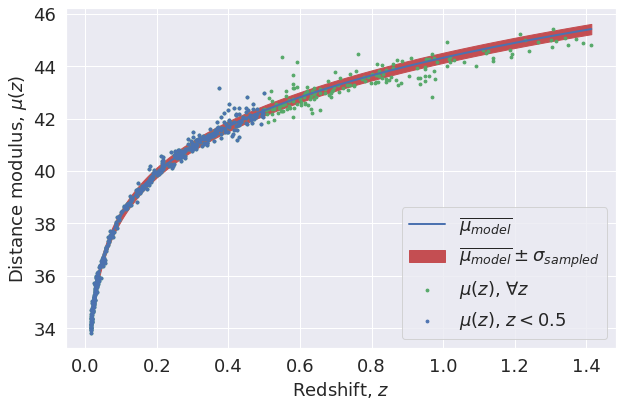

In [31]:
# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

with our_mu_model:
    posterior_draws = pm.sample_posterior_predictive(trace_NUTS_mu, var_names=["theta", "q0", "sigma2"], 
                                                     samples=1000, random_seed=123);
fig, ax = plt.subplots(figsize=(9,6))
sample_trajectories = np.zeros((posterior_draws['theta'].shape[0], len(z)))
for idx, theta_sample in enumerate(posterior_draws['theta']):
    epsilon = np.random.normal(scale=np.sqrt(posterior_draws['sigma2'][idx]))
    # Add noise and calculate one sample of dl(z)
    mu_sample = mu_model(z, theta_sample,posterior_draws['q0'][idx]) + epsilon
    # Save and plot the mu sample
    sample_trajectories[idx, :] = mu_sample
#     if(idx == 0):
#         ax.plot(z, mu_sample, color='black',alpha=1, label='Posterior sample of $\mu_{model}(z, \\theta, q_0,\sigma)$')
#     else: 
#         ax.plot(z, mu_sample, color='black',alpha=0.05)

# Plot mean posterior predictive and +-1 sigma band
mu_mean = np.mean(sample_trajectories, axis=0)
mu_std = np.std(sample_trajectories, axis=0)
ax.fill_between(x=z, y1=mu_mean+mu_std, y2=mu_mean-mu_std, color='r', label='$\overline{\mu_{model}} \pm \sigma_{sampled} $')
ax.plot(z, mu_mean, c='b', linewidth=2, label='$\overline{\mu_{model}}$')
     
ax.scatter(z, mu, s = 8, c='g', label=r'$\mu(z)$, $\forall z$')
ax.scatter(low_z,low_mu, s = 8, label=r'$\mu(z)$, $z<0.5}$')
ax.legend(loc='best')
ax.set_xlabel(r'Redshift, $z$')
ax.set_ylabel(r'Distance modulus, $\mu(z)$')
plt.tight_layout()
plt.savefig('figures_task1/predictive_plot_mu.png')